In [15]:
import numpy as np
from skimage import io
import os
import sys
import matplotlib.pyplot as plt
from scipy.io import loadmat
from natsort import natsorted
import random
import cv2

In [23]:
# dataset_dir = '/home/sh38/wb_cells/datasets/wbc_1024x1024/'
dataset_dir = '/home/sh38/wb_cells/datasets/wbc3_1024x1024/'
image_dir = dataset_dir + '/images'
map_dir = dataset_dir + 'seg_maps'
box_dir = dataset_dir + 'boxes'
fns = os.listdir(box_dir)
print(len(fns))

504


In [17]:
def read_boxes(file_name):
    boxes = []
    with open(file_name, 'r+') as f:
        for line in f.readlines():
            splits = line.strip().split(',')
            boxes.append([(int(splits[0]), int(splits[1])), (int(splits[2]), int(splits[3]))])
    return boxes

def generate_folder(folder):
    if not os.path.exists(folder):
        os.system('mkdir -p {}'.format(folder))

[49, 325]
[(367, 518), (435, 583)]
367 518 435 583
209 593 358 742
(384, 384, 3) (384, 384)
[(326, 923), (493, 1023)]
326 923 493 1023
217 601 781 1165
(384, 384, 3) (384, 384)


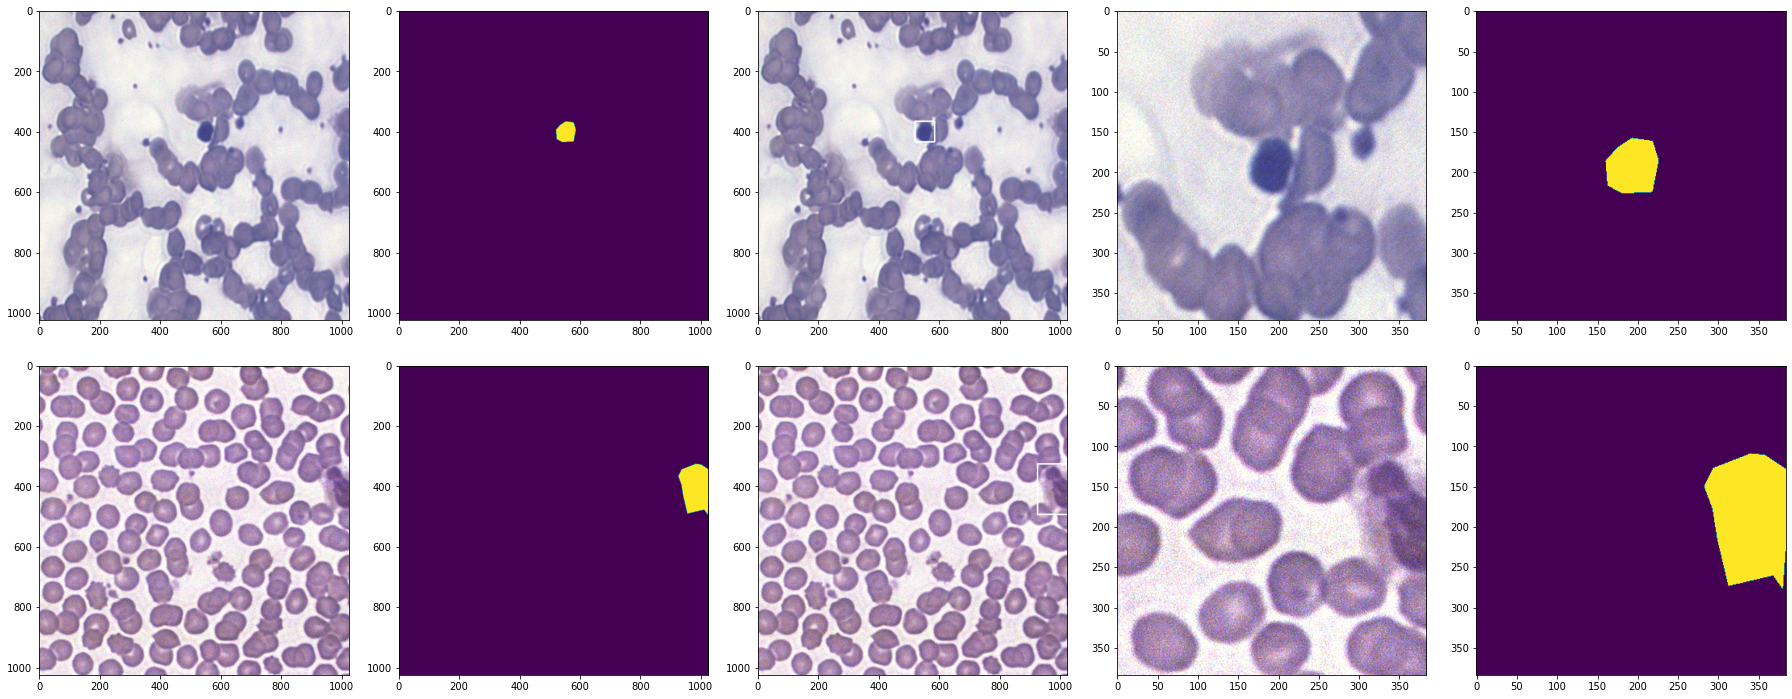

In [24]:
# check the bounding boxes
num = 2
dim = 384; hf = dim // 2
indicies = random.sample(range(len(fns)), num)
rows, cols, size = num, 5, 5
fig = plt.figure(tight_layout=True,figsize=(size*cols, size*rows))
ax = fig.subplots(rows, cols)
print(indicies)
for i in range(2):
    img_index = indicies[i]
    # print(fns[img_index])
    image_file = image_dir + '/{}'.format(fns[img_index].replace('.txt', '.png'))
    map_file = map_dir + '/{}'.format(fns[img_index].replace('.txt', '.tif'))
    box_file = box_dir + '/{}'.format(fns[img_index])
    image = io.imread(image_file); # print(image.shape, image.max(), image.min())
    seg_map = io.imread(map_file); # print(seg_map.shape, seg_map.max(), seg_map.min())
    ax[i,0].imshow(image)
    ax[i,1].imshow(seg_map)
    image_copy = image.copy()
    boxes = read_boxes(box_file)
    for box in boxes:
        print(box)
        h, w = box[0][1] - box[1][1], box[0][0] - box[1][0]
        #cv2.rectangle(image_copy, (x, y), (x + w, y + h), (36,255,12), 2)
        cv2.rectangle(image_copy, (box[1][1], box[1][0]), (box[0][1], box[0][0]), (255, 255, 255), 3)
        #cv2.rectangle(image_copy, (box[1][1] - h, box[1][0] - w), (box[1][1] + h, box[1][0] + w), (255, 255, 255), 3)
    ax[i,2].imshow(image_copy)
    shp = image.shape
    cp_img_list = []
    cp_map_list = []
    for j in range(len(boxes)):
        tlx, tly = boxes[j][0]
        drx, dry = boxes[j][1]
        print(tlx, tly, drx, dry)
        #hx, hy = drx - tlx, dry - tly
        cx, cy = (tlx + drx) // 2, (tly + dry) // 2
        ctlx, cdrx, ctly, cdry = cx - hf, cx + hf, cy - hf, cy + hf
        print(ctlx, cdrx, ctly, cdry)
        if ctlx < 0:
            cdrx += 0 - ctlx
            ctlx = 0
        if ctly < 0:
            cdry += 0 - ctly
            ctly = 0
        if cdrx > shp[0]: 
            ctlx -= (cdrx - shp[0])
            cdrx = shp[0]
        if cdry > shp[1]: 
            ctly -= (cdry - shp[1])
            cdry = shp[1]
        cp_img = image[ctlx:cdrx, ctly:cdry]
        cp_map = seg_map[ctlx:cdrx, ctly:cdry]
        print(cp_img.shape, cp_map.shape)
        cp_img_list.append(cp_img)
        cp_map_list.append(cp_map)
    ax[i,3].imshow(cp_img_list[0])
    ax[i,4].imshow(cp_map_list[0])

714 [[(207, 598), (370, 761)], [(506, 671), (612, 767)], [(901, 203), (999, 287)]]
714 714
x side: 242.000 0.000
y side: 302.000 0.000


(array([  3.,  22., 184., 158., 112., 130.,  87.,  15.,   1.,   2.]),
 array([  0. ,  30.2,  60.4,  90.6, 120.8, 151. , 181.2, 211.4, 241.6,
        271.8, 302. ]),
 <a list of 10 Patch objects>)

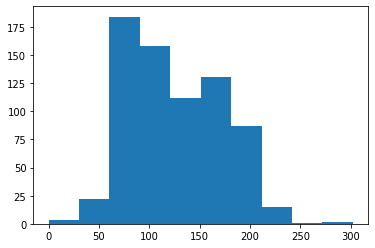

In [25]:
# check the object sizes
all_boxes = []
for img_index, fn in enumerate(fns):
    box_file = box_dir + '/{}'.format(fns[img_index])
    boxes = read_boxes(box_file)
    all_boxes += boxes
print(len(all_boxes), all_boxes[:3])
xsizes, ysizes = [], []
for box in all_boxes:
    xsizes.append(box[1][0]-box[0][0])
    ysizes.append(box[1][1]-box[0][1])
print(len(xsizes), len(ysizes))
print('x side: {:.3f} {:.3f}'.format(np.max(xsizes), np.min(xsizes)))
print('y side: {:.3f} {:.3f}'.format(np.max(ysizes), np.min(ysizes)))
# axs = plt.subplots(1,2,5)
#plt.hist(xsizes)
plt.hist(ysizes)

In [26]:
''' Prepare crop datset for segmentaiton
'''
dim = 384; hf = dim // 2
h, w = dim // 2, dim // 2
crop_dataset = dataset_dir + '/crop'
crop_image_dir = crop_dataset + '/images'
crop_map_dir =  crop_dataset + '/seg_maps'
generate_folder(crop_image_dir)
generate_folder(crop_map_dir)
for img_index, fn in enumerate(fns):
    image_file = image_dir + '/{}'.format(fns[img_index].replace('.txt', '.png'))
    map_file = map_dir + '/{}'.format(fns[img_index].replace('.txt', '.tif'))
    box_file = box_dir + '/{}'.format(fns[img_index])
    image = io.imread(image_file); #print(image.shape, image.max(), image.min())
    seg_map = io.imread(map_file); #print(seg_map.shape, seg_map.max(), seg_map.min())    
    box_file = box_dir + '/{}'.format(fns[img_index])
    boxes = read_boxes(box_file)
    shp = image.shape
    for j in range(len(boxes)):
        tlx, tly = boxes[j][0]
        drx, dry = boxes[j][1]
        cx, cy = (tlx + drx) // 2, (tly + dry) // 2
        ctlx, cdrx, ctly, cdry = cx - hf, cx + hf, cy - hf, cy + hf
        if ctlx < 0:
            cdrx += 0 - ctlx
            ctlx = 0
        if ctly < 0:
            cdry += 0 - ctly
            ctly = 0
        if cdrx > shp[0]: 
            ctlx -= (cdrx - shp[0])
            cdrx = shp[0]
        if cdry > shp[1]: 
            ctly -= (cdry - shp[1])
            cdry = shp[1]
        cp_img = image[ctlx:cdrx, ctly:cdry]
        cp_map = seg_map[ctlx:cdrx, ctly:cdry]        
        if cp_img.shape == (dim, dim, 3):
            io.imsave(crop_image_dir + '/{}_{:02d}.png'.format(fn.replace('.txt',''), j), cp_img)
            io.imsave(crop_map_dir + '/{}_{:02d}.tif'.format(fn.replace('.txt',''),j), cp_map)
        else:
            print('different shape {}x{}'.format(cp_img.shape[0], cp_img.shape[1]))
    
    if img_index % 100 == 0:
        print('{} processed! '.format(img_index))

0 processed! 
100 processed! 
200 processed! 
300 processed! 
400 processed! 
500 processed! 


In [13]:
''' prepare bounding box labels as VOC2012 dataset
in the numpy array: the xs, ys correspond to the row and col direction, respectively
in the VOC2012 dataset: the xs, ys correspond to the col and row directions, respectively
'''
def read_boxlines(file_name):
    boxes = []
    with open(file_name, 'r+') as f:
        for line in f.readlines():
            splits = line.strip().split(',')
            boxes.append([int(splits[1]), int(splits[0]), int(splits[3]), int(splits[2])]) # xmin, ymin, xmax, ymax
    return boxes

def write_boxes(annot_file_name, img_fn, boxes):
    with open(file_name, 'w+') as f:
        f.write('<annotation>\n')
        f.write('  <filename>{}<filename>\n'.format(img_fn))
        f.write('  <object><object>'.format())

output_dir = dataset_dir + '/voc_annot'
box_dir = dataset_dir + '/boxes'
image_dir = dataset_dir + '/images'
img_fns = natsorted(os.listdir(image_dir))
fns = natsorted(os.listdir(box_dir))
print(len(fns), fns[:10])
# for i, fn in enumerate(fns):
fn = fns[0]
boxes = read_boxlines(box_dir + '/{}'.format(fn)); print(boxes)

504 ['0000.txt', '0001.txt', '0002.txt', '0003.txt', '0004.txt', '0005.txt', '0006.txt', '0007.txt', '0008.txt', '0009.txt']
[[598, 207, 761, 370]]
